# <font color="blue">Customer Segmentation using k-means clustering</font>

## <strong>Why k-Means:</strong>
 - Simple and fast
 - Most popular supervised learning model

## Assumptions
 - Distributions are symmetric
 - Variables have same average values (scale)
 - Variables with same variance (scale)
 
## Workflow
  1. Data processing
  2. Cluster number selection
  3. Run k-means clustering
  4. Analyze mean RFM Values of each cluster

# Import Modules

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
# from datetime import datetime
import datetime as dt

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# K-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Import Data

In [2]:
# import data
df = pd.read_excel("static/data/online_retail.xlsx", sheet_name="Online Retail")

In [3]:
# Explore datatypes
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

# <font color="blue">Part 1: Data pre-processing</font>

 - Step 1: Clean data (drop missing values in CustomerID; change datatypes as needed)
 - Step 2: Calculate Recency, Frequency, and Monetary Value
 - Step 3: Manage skewed variables

## Step 1: Clean data

In [4]:
# Drop rows that have missing customerID 
df = df.dropna(subset=['CustomerID'])

In [5]:
# Convert customerID column to integers and remove the period and decimal place
df['CustomerID'] = df['CustomerID'].astype(str).replace('\.0', '', regex=True).astype('int')

In [6]:
# Confirm CustomerID has been updated
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


## Step 2: Calculate Recency, Frequency, and Monetary Value

 - a: Define time period and filter data accordingly
 - b: Calculate the Sales Revenue per Transaction
 - c: Calculate the Recency, Frequency, Monetary Value for a specific day

### a: Filter Data to Specific Time Period

In [7]:
# Create a subset of the dataframe that is filtered for most recent year of activity
subset_df = df[df['InvoiceDate']>'2010-12-10'].copy()

In [8]:
# Confirm subset dates
print('Min: {}; Max: {}'.format(min(subset_df.InvoiceDate),
                              max(subset_df.InvoiceDate)))

Min: 2010-12-10 09:33:00; Max: 2011-12-09 12:50:00


### b: Calculate the Sales Revenue per Transaction

In [9]:
# Create a sales revenue column named <code>TotalSum</code>
subset_df["TotalSum"] = subset_df["Quantity"]*subset_df["UnitPrice"]

In [17]:
# Filter out instances where the company made no money
# customers that the business lost money should be analyzed separately
subset_df = subset_df[subset_df["TotalSum"] > 0].copy()

### c: Calculate the Recency, Frequency, Monetary Value for a specific day

In [19]:
# Create snapshot_day
snapshot_date = max(subset_df.InvoiceDate) + dt.timedelta(days=1)

In [20]:
# Display date
snapshot_date

Timestamp('2011-12-10 12:50:00')

### Create a new grouped dataset <font color="blue">rfm_data</font>

In [21]:
# Aggregate data (Recent day "snapshot_date" - last transaction)
rfm_data = subset_df.groupby(["CustomerID"]).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'count',
    'TotalSum' : 'sum'})

In [22]:
# Inspect data
rfm_data.head(3)

,InvoiceDate,InvoiceNo,TotalSum
CustomerID,,,
12346,326,1,77183.60
12347,2,151,3598.21
12348,75,31,1797.24


<div style="border:1px solid black; padding:10px">
<font color="blue">Comment</font>
- Notice invoice date is not longer an actual date datatype, but an integer that represents the number of dates since the last invoice date
- CustomerID 12346 hasn't been a customer in almost a year, has had two transcations, but spent $0.00. The customer received a refund, making the amount 0.
</div>

In [23]:
# Rename columns for easier interpretation
rfm_data.rename(columns = {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : 'Frequency',
                          'TotalSum': 'Monetary Value'}, inplace=True)

In [24]:
# Inspect the relabeled data
rfm_data.head(3)

,Recency,Frequency,Monetary Value
CustomerID,,,
12346,326,1,77183.60
12347,2,151,3598.21
12348,75,31,1797.24


# Step 3: Manage skewed variables

 - Step a: Evaluate variable statistics
 - Step b: Plot variable distribution
 - Step c: Normalize the variables with <code>StandardScaler</code>

### a: Evaluate variable statistics

In [25]:
rfm_data.describe()

,Recency,Frequency,Monetary Value
count,4264.000000,4264.000000,4264.000000
mean,87.718809,89.910882,2016.775306
std,93.890406,223.984026,8784.825211
min,1.000000,1.000000,3.750000
25%,17.750000,17.000000,304.905000
50%,50.000000,41.000000,668.125000
75%,133.250000,98.000000,1636.362500
max,365.000000,7661.000000,280206.020000


In [65]:
# Store rfm_data variable so that it can be used in a separate notebook
%store rfm_data

Stored 'rfm_data' (DataFrame)


<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
The mean for Recency, Frequency, and Monetary Value Vary and so does the variance.
k-means clustering relies on these two assumptions:
 - Variables have same average values 
 - Variables with same variance

We will need to characterize the skewness and they apply methods to scale variables so these assumptions are met.
</div>

#### Step b: Plot variable distribution

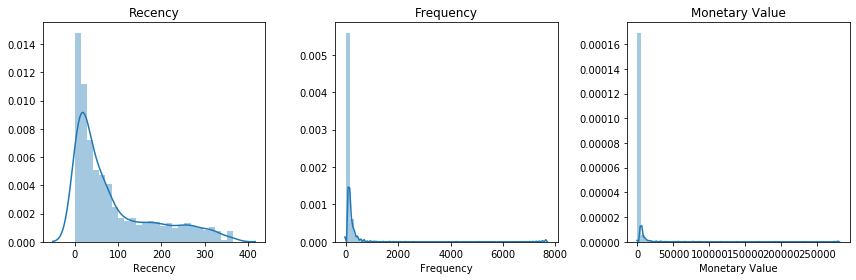

In [26]:
# Plot distribution
rfm_variables = ["Recency", "Frequency", "Monetary Value"]
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for axes, var in zip(axes.ravel(), rfm_variables):
    axes.set_title(var)
    sns.distplot(rfm_data[var], ax=axes)

plt.tight_layout()
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

# Sequence of structuring pre-processing steps

 - Unskew the data - log transformation
 - Standardize to the same average values
 - Scale to the same standard deviation
 - Store as a separate array to be used for clustering

In [30]:
# Unskew the data with log transformation
dataset_log = np.log(rfm_data)

In [31]:
dataset_log.describe()

,Recency,Frequency,Monetary Value
count,4264.000000,4264.000000,4264.000000
mean,3.730286,3.668956,6.578753
std,1.416391,1.316384,1.256086
min,0.000000,0.000000,1.321756
25%,2.876082,2.833213,5.720000
50%,3.912023,3.713572,6.504475
75%,4.892222,4.584967,7.400231
max,5.899897,8.943898,12.543280


In [ ]:
# Store variable so that it can be used in a separate notebook
%store dataset_log

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
The mean and standard deviation of the log transformed Recency, Frequency, and Monetary Value are close in range.
</div>

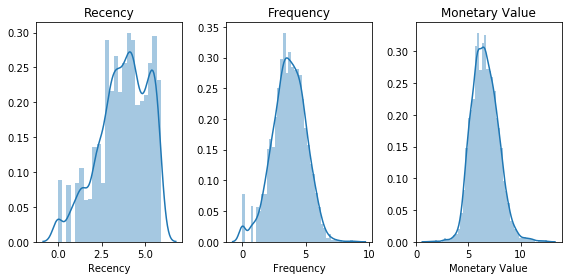

In [32]:
# Plot distribution
variables = dataset_log.columns
fig, axes = plt.subplots(1, 3, figsize=(8,4))
for axes, var in zip(axes.ravel(), variables):
    axes.set_title(var)
    sns.distplot(dataset_log[var], ax=axes)

plt.tight_layout()
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

<b><font color="blue">Note:</font><br>
The variables now have means and standard deviations that are closer in magnitude.</b>

### e: Normalize the variables with <code>StandardScaler</code

In [33]:
# Normalize the variables with StandardScaler
scaler = StandardScaler()
scaler.fit(dataset_log)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
dataset_normalized = scaler.transform(dataset_log)
df_normalized = pd.DataFrame(dataset_normalized, index=dataset_log.index, columns=dataset_log.columns)

# <font color="blue">Part II: Cluster number selection</font>

 - Visual methods: Elbow criterion
 - Mathematical methods: silhouette coefficient

# Elbow citerion method

 - Plot the number of clusters against within-cluster sum-of-squared-erros (SSE)- sum of squared distances from every data point to their cluster center
 - The 'Elbow' represents an 'optimal' number of clusters

In [35]:
# Create an empty dictionary
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_normalized)
    sse[k] = kmeans.inertia_

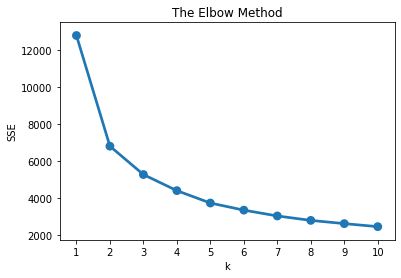

In [36]:
# Plot SSE for each k 'cluster'
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
Criteria points to 2 clusters as the solutions
</div>

# Experimental Approach - Analyze Segments

 - Build clustering at and around elbow solution
 - Analyze average RFM values
 - Compare against other solutions and identify which provides most insight

In [37]:
kmeans3 = KMeans(n_clusters=3, random_state=1)
# compute k-means clustering on pre-processed data
kmeans3.fit(df_normalized)
# Extract cluster labels using <code>labels_</code> attribute
cluster_labels = kmeans3.labels_
rfm_dataset_cluster3 = rfm_data.assign(Cluster = cluster_labels)
rfm_dataset_cluster3.groupby(["Cluster"]).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value': ["mean", 'count']
}).round(0)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0          13.0     257.0         6398.0   943
1         160.0      15.0          288.0  1491
2          67.0      65.0         1167.0  1830

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font>
    <ul>
        <li>In this example, there are three clusters that are defined by ther mean recency, frequency, and amount they have spent.</li>
        <li>The monetary count provides the number of purchases.</li>
        <li>Customers in cluster 0 have made recent purchases, make more visits, and spend more per transaction.</li>
        <li>Customers in cluster 1 have not made recent purchases, dont make that many visits, and spend less per transaction than customers in cluster 0 and 2.</li>
        <li>Customers in cluster 2 are customers whose profiles are between cluster 0 and 1.
    </ul>
    
</div>

### Profile and Interpret Segments

Approaches to build customer personas
 - Summary statistics for each cluster
 - Snake plots
 - Calcualte relative importance of cluster attributes compared to population

### Snake plots
 - Market research technique to compare different segments
 - Visual representation of each segment's attributes
 - Need to first normalize data (center and scale)
 - Plot each clusters average normalized values of each attribute

In [38]:
df_normalized['Cluster'] = rfm_dataset_cluster3['Cluster']

In [39]:
df_normalized.replace({'Cluster': {0: 'One', 1: 'Two', 2:'Three'}}, inplace=True)

In [40]:
df_normalized[df_normalized['Cluster']=='Three'].head(3)

,Recency,Frequency,Monetary Value,Cluster
CustomerID,,,,
12346,1.452179,-2.787474,3.722467,Three
12348,0.414625,-0.178517,0.728742,Three
12349,-0.554888,0.472185,0.710961,Three


In [41]:
df_melt = pd.melt(df_normalized.reset_index(),
                 id_vars=['CustomerID', 'Cluster'],
                 value_vars = ['Recency', 'Frequency', 'Monetary Value'],
                  var_name='Attribute',
                  value_name='Value'
                 )

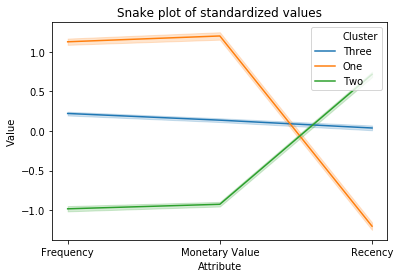

In [42]:
plt.title('Snake plot of standardized values')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_melt)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

### Relative importance of segment attributes
 - identify relative importance of each segment's attribute
 - calculate average values of each cluster
 - calcualte average values of population

In [43]:
cluster_avg = rfm_dataset_cluster3.groupby(['Cluster']).mean()
population_avg = rfm_data.mean()

In [44]:
relative_imp = cluster_avg/population_avg - 1

### Analyze and plot relative importance

 - further ratio is from 0, the more important that attribute is for a segment, relative to the total population

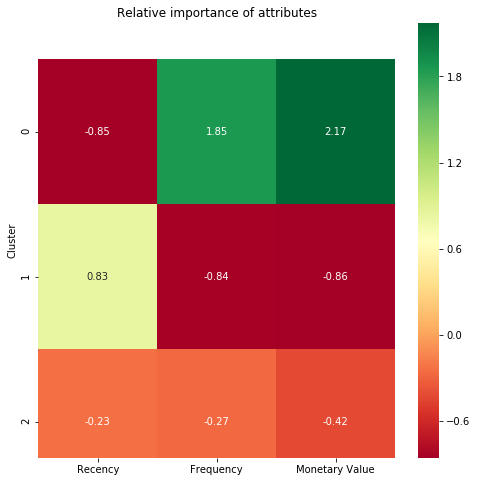

In [45]:
plt.figure(figsize=(8,8))
plt.title('Relative importance of attributes')
chart = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
# Makes sure the plot is visible
chart.set_ylim(len(relative_imp)-0.25, -0.25)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

# Centering and Scaling Variables

 - Centering variables id done by subtracting average values from each observation

In [46]:
# Aggregate data (Recent day - last transaction)
rfm_dataset = subset_df.groupby(["CustomerID"]).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'count',
    'TotalSum' : 'sum'})

In [47]:
# Rename columns for easier interpretation
rfm_dataset.rename(columns = {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : 'Frequency',
                          'TotalSum': 'Monetary Value'}, inplace=True)

In [48]:
rfm_dataset = rfm_dataset[rfm_dataset["Monetary Value"]>0]

In [49]:
rfm_dataset.head()

,Recency,Frequency,Monetary Value
CustomerID,,,
12346,326,1,77183.60
12347,2,151,3598.21
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [50]:
frequency_log = np.log(rfm_data.Frequency)
recency_log = np.log(rfm_data.Recency)

In [51]:
data = {"frequency_log": frequency_log, "recency_log": recency_log}
rf_log = pd.DataFrame.from_dict(data)

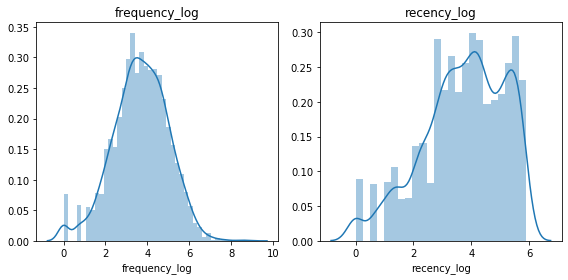

In [52]:
# Plot distribution
rfm_log_variables = rf_log.columns
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for axes, var in zip(axes.ravel(), rfm_log_variables):
    axes.set_title(var)
    sns.distplot(rf_log[var], ax=axes)

plt.tight_layout()
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

# Combining centering and scaling
 - use scaler from <code>scikit-learn</code>

In [53]:
scaler = StandardScaler()
scaler.fit(rfm_data)
rfm_normalized = scaler.transform(rfm_data)

In [54]:
print('mean:', rfm_normalized.mean(axis=0).round(2))
print('std:', rfm_normalized.std(axis=0).round(2))

mean: [ 0.  0. -0.]
std: [1. 1. 1.]


# Practical Implementation of k-means clustering

 - Data pre-processing
 - Chossing a number of clusters
 - Running k-means clustering on pre-processed data
 - Analyzing average RFM values of each cluster

In [55]:
kmeans = KMeans(n_clusters=2, random_state=1)

In [60]:
# Create a subset of the normalized dataframe that does not contain the cluster column
km_normalized = df_normalized.drop(['Cluster'], axis=1).copy()

In [61]:
# compute k-means clustering on pre-processed data
kmeans.fit(km_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [62]:
# Extract cluster labels using <code>labels_</code> attribute
cluster_labels = kmeans.labels_

### Analyze average RFM values of each cluster
 - Create a cluster label column in the original dataframe
 - Calculte average RFM values and size for each cluster

In [63]:
rfm_dataset_cluster = rfm_dataset.assign(Cluster = cluster_labels)

In [64]:
rfm_dataset_cluster.groupby(["Cluster"]).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value': ["mean", 'count']
}).round(0)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0         134.0      25.0          467.0  2367
1          30.0     171.0         3951.0  1897

# Notes
 - Clean up last portion
 - Break this up into several jupyter notebooks
 - carry over variables